In [73]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import random

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd



In [46]:
SR = 44100  # Ziel-Samplerate (alle werden resampled)
DATA_DIR = "data"
# Beispiel: alle Audios einlesen
samples = {"fett": [], "dry": []}


In [47]:
for label in ["fett", "dry"]:
    folder = os.path.join(DATA_DIR, label)
    for filename in os.listdir(folder):
        if filename.endswith(".wav"):
            filepath = os.path.join(folder, filename)
            y, sr = librosa.load(filepath, sr=SR)
            samples[label].append({
                "signal": y,
                "sr": sr,
                "label": label,
                "filename": filename
            })

In [48]:
print(f"Gefettet: {len(samples['fett'])} Dateien")
print(f"Trocken:  {len(samples['dry'])} Dateien")

Gefettet: 14 Dateien
Trocken:  26 Dateien


In [49]:
def segment_audio(samples_dict, sr=44100, segment_length=1.0):
    seg_len = int(segment_length * sr)
    segments = []

    for label, audio_list in samples_dict.items():
        for i, sample in enumerate(audio_list):
            y = sample["signal"]
            n_segments = len(y) // seg_len
            for j in range(n_segments):
                start = j * seg_len
                end = start + seg_len
                seg = y[start:end]
                segments.append({
                    "signal": seg,
                    "label": label,
                    "orig_filename": sample["filename"],
                    "segment_index": j
                })
    return segments

In [94]:
# Beispiel: 1.0 Sekunden pro Segment
segments = segment_audio(samples, sr=SR, segment_length=1.0)
print(f"Gesamtanzahl Segmente: {len(segments)}")
print(f"Beispiel: {segments[0]['label']} | Signal-Länge: {len(segments[0]['signal'])/44100:.2f}s")


Gesamtanzahl Segmente: 104
Beispiel: fett | Signal-Länge: 1.00s


In [95]:
n_per_class = 3

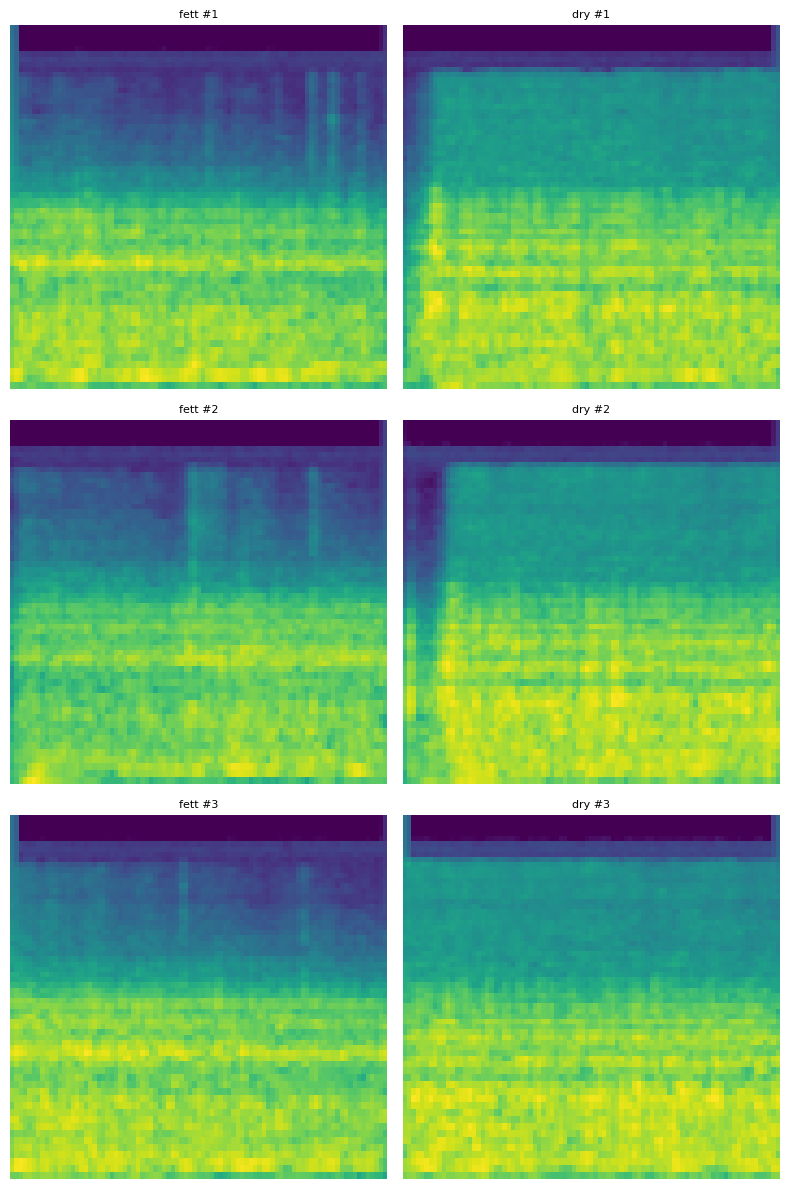

In [99]:
# 5 zufällige Segmente pro Klasse auswählen
selected_segments = {
    label: random.sample([s for s in segments if s["label"]==label], n_per_class)
    for label in classes
}

plt.figure(figsize=(8, 12))  # 2 Spalten × 5 Zeilen

for row in range(n_per_class):
    for col, label in enumerate(classes):
        seg = selected_segments[label][row]
        y = seg["signal"]
        S = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=64)
        S_db = librosa.power_to_db(S, ref=np.max)

        plt.subplot(n_per_class, 2, row*2 + col + 1)
        librosa.display.specshow(S_db, sr=SR, x_axis='time', y_axis='mel', cmap='viridis')
        plt.title(f"{label} #{row+1}", fontsize=8)
        plt.axis("off")

plt.tight_layout()
plt.show()

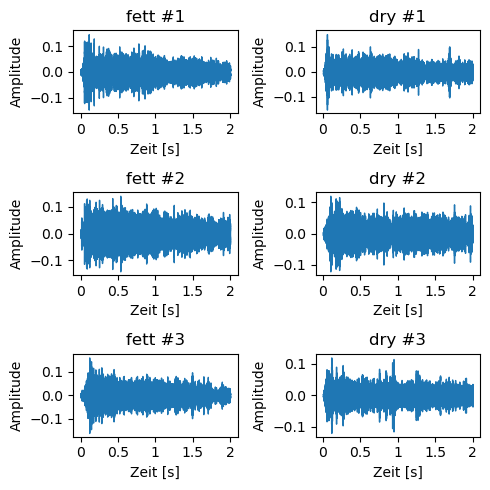

In [53]:
plt.figure(figsize=(5, 5))

for i, label in enumerate(["fett", "dry"]):
    # 5 zufällige Samples auswählen
    selected = random.sample(samples[label], min(n_per_class, len(samples[label])))
    
    for j, sample in enumerate(selected):
        y = sample["signal"][:sample["sr"]*2]  # max 2 Sekunden
        ax = plt.subplot(n_per_class, 2, j*2 + i + 1)
        librosa.display.waveshow(y, sr=sample["sr"])
        ax.set_title(f"{label} #{j+1}")
        ax.set_xlabel("Zeit [s]")
        ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [54]:
rms_values = {"fett": [], "dry": []}

for label in ["fett", "dry"]:
    for sample in samples[label]:
        y = sample["signal"]
        rms = np.sqrt(np.mean(y**2))
        rms_values[label].append(rms)

avg_rms_fett = np.mean(rms_values["fett"])
avg_rms_dry = np.mean(rms_values["dry"])
print(f"Durchschnittliche Lautstärke (RMS):")
print(f"Fett:  {avg_rms_fett:.4f}")
print(f"Dry:   {avg_rms_dry:.4f}")

Durchschnittliche Lautstärke (RMS):
Fett:  0.0218
Dry:   0.0176


In [55]:
for label in ["fett", "dry"]:
    for sample in samples[label]:
        y = sample["signal"]
        # Peak-Normalisierung auf -1…1
        y_norm = librosa.util.normalize(y)
        sample["signal"] = y_norm

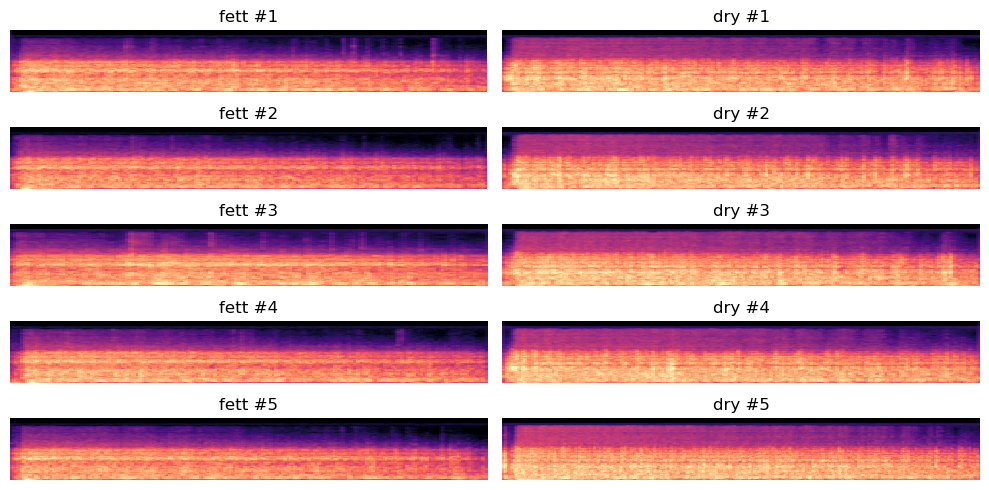

In [93]:
plt.figure(figsize=(10, 5))

for i, label in enumerate(["fett", "dry"]):
    for j, sample in enumerate(random.sample(samples[label], 5)):
        y = sample["signal"]
        S = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=64)
        S_db = librosa.power_to_db(S, ref=np.max)

        plt.subplot(5, 2, i + 1 + j * 2)
        librosa.display.specshow(S_db, sr=SR, x_axis='time', y_axis='mel')
        plt.title(f"{label} #{j+1}")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [57]:
def extract_features(segments, sr=44100, n_mels=40):
    X = []
    y = []

    for seg in segments:
        S = librosa.feature.melspectrogram(y=seg["signal"], sr=sr, n_mels=n_mels)
        S_db = librosa.power_to_db(S, ref=np.max)
        feature_vector = np.mean(S_db, axis=1)  # Mittelwert pro Mel-Band
        X.append(feature_vector)
        y.append(seg["label"])
    
    return np.array(X), np.array(y)

X, y_labels = extract_features(segments)


In [78]:
# Feature-Matrix in DataFrame umwandeln
df_features = pd.DataFrame(X, columns=[f"mel_{i+1}" for i in range(X.shape[1])])
df_features["label"] = y_labels

df_features["mel_35"]

0     -62.269733
1     -61.445908
2     -62.555950
3     -63.310070
4     -62.228054
         ...    
99    -44.317013
100   -50.272297
101   -50.920315
102   -46.177917
103   -51.604179
Name: mel_35, Length: 104, dtype: float32

              precision    recall  f1-score   support

        fett       1.00      1.00      1.00         6
         dry       1.00      1.00      1.00        15

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Confusion Matrix:
 [[ 6  0]
 [ 0 15]]


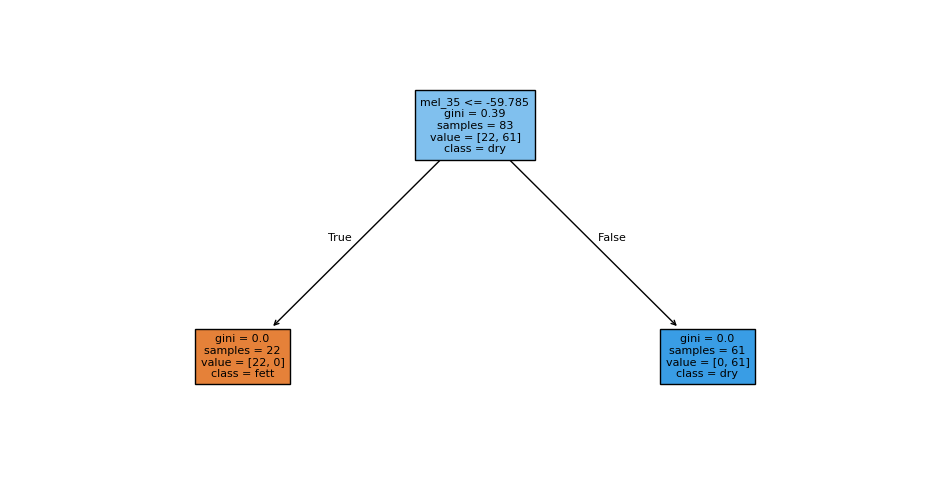

In [87]:
# Labels in 0/1 umwandeln
y = np.array([0 if label=="fett" else 1 for label in y_labels])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# Decision Tree trainieren
tree = DecisionTreeClassifier(max_depth=3, random_state=42)  # flacher Baum = besser interpretierbar
tree.fit(X_train, y_train)

# Vorhersagen
y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["fett","dry"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Baum plotten
plt.figure(figsize=(12,6))
plot_tree(tree, feature_names=[f"mel_{i+1}" for i in range(X.shape[1])],
          class_names=["fett","dry"], filled=True, fontsize=8)
plt.show()

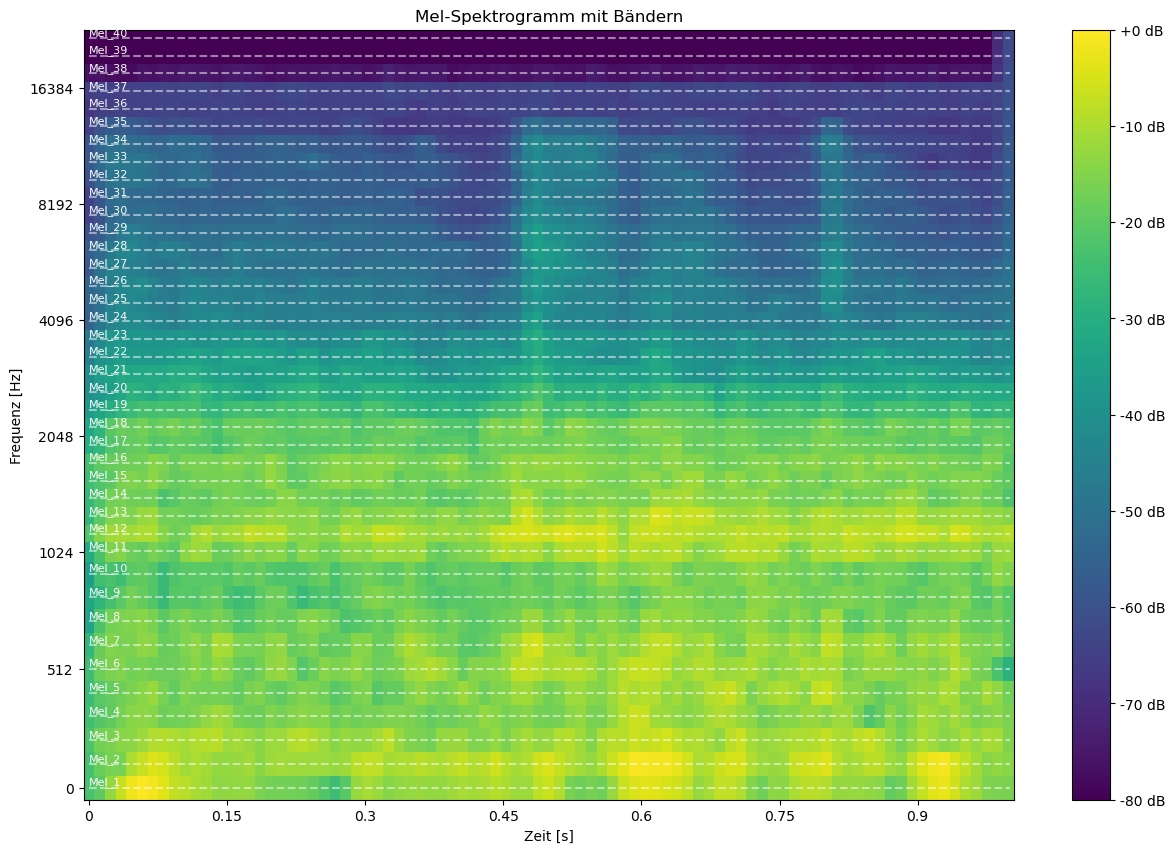

In [88]:
# Zufälliges Segment nehmen
seg = segments[0]
y = seg["signal"]
sr = 44100

# Mel-Spektrogramm
n_mels = 40
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(15, 10))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel-Spektrogramm mit Bändern")

# Mel-Band-Linien einzeichnen
mel_frequencies = librosa.mel_frequencies(n_mels=n_mels, fmin=0, fmax=sr/2)
for i, freq in enumerate(mel_frequencies):
    plt.hlines(freq, xmin=0, xmax=len(y)/sr, colors='white', linestyles='dashed', alpha=0.5)
    plt.text(0, freq, f"Mel_{i+1}", color='white', fontsize=8, va='bottom')

plt.xlabel("Zeit [s]")
plt.ylabel("Frequenz [Hz]")
plt.show()